# Example working with EMIT over Libya-4

EMIT_L1B_RAD_001_20220827T091626_2223906_009

comparable to Fig 23 in Thompson et al. (2023)

In [1]:
import hyperquest

import matplotlib.pyplot as plt
from skimage.segmentation import slic, mark_boundaries
from sklearn.decomposition import PCA
import rasterio
import numpy as np

In [2]:
# Define path to envi image header file
hdr_path = '/Users/brent/Code/HyperQuest/tests/data/SISTER_EMIT_L1B_RDN_20220827T091626_000.hdr'
img_path = '/Users/brent/Code/HyperQuest/tests/data/SISTER_EMIT_L1B_RDN_20220827T091626_000.bin'

# get wavelengths
wavelengths = hyperquest.read_center_wavelengths(hdr_path)

wavelengths


array([ 381.00558472,  388.40921021,  395.81582642,  403.22540283,
        410.63800049,  418.05358887,  425.47213745,  432.8927002 ,
        440.31726074,  447.74279785,  455.17034912,  462.59887695,
        470.03039551,  477.46292114,  484.89743042,  492.33291626,
        499.77142334,  507.2098999 ,  514.65039062,  522.09088135,
        529.5333252 ,  536.97680664,  544.42126465,  551.86669922,
        559.31420898,  566.76159668,  574.20904541,  581.6585083 ,
        589.10797119,  596.55834961,  604.00982666,  611.46221924,
        618.91461182,  626.36804199,  633.82147217,  641.27587891,
        648.73028564,  656.18572998,  663.64111328,  671.09753418,
        678.55389404,  686.01031494,  693.4677124 ,  700.92510986,
        708.38354492,  715.84094238,  723.29931641,  730.75872803,
        738.21710205,  745.67651367,  753.13592529,  760.59631348,
        768.0557251 ,  775.51611328,  782.97753906,  790.43792725,
        797.89935303,  805.36175537,  812.82318115,  820.28460

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


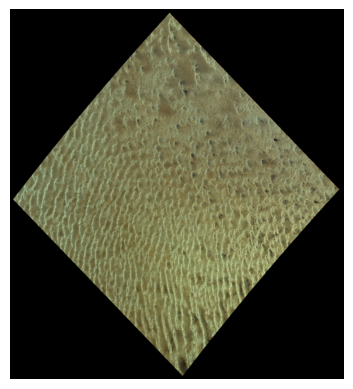

In [3]:
# Open the raster file
with rasterio.open(img_path) as src:
    red = src.read(39)
    green = src.read(24)
    blue = src.read(11)
    array = src.read()

red= np.ma.masked_equal(red, -9999)
green = np.ma.masked_equal(green, -9999)
blue = np.ma.masked_equal(blue, -9999)

# Normalize the values for display
red_normalized = (red - red.min()) / (red.max() - red.min())
green_normalized = (green - green.min()) / (green.max() - green.min())
blue_normalized = (blue - blue.min()) / (blue.max() - blue.min())
rgb_image = np.dstack((red_normalized, green_normalized, blue_normalized))
plt.imshow(rgb_image)
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


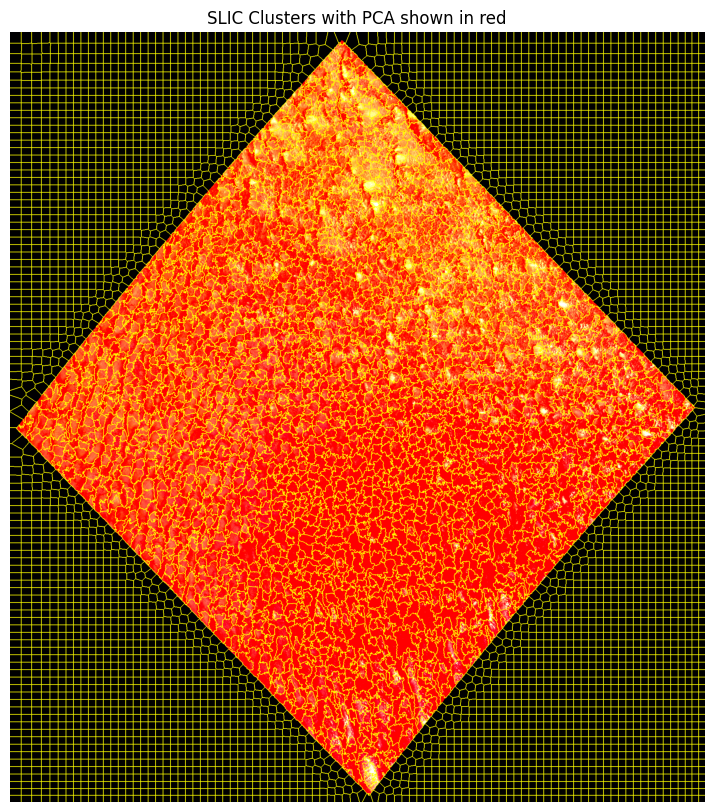

In [15]:
# Open the raster file
with rasterio.open(img_path) as src:
    array = src.read()

# Rearrange to (rows, cols, bands) for segmentation
array = np.moveaxis(array, 0, -1)

# first 3 components
pca = PCA(n_components=3)
rows, cols, bands = array.shape
array_reshaped = array.reshape(-1, bands)
array_pca = pca.fit_transform(array_reshaped).reshape(rows, cols, -1)

# SLIC
n_segments = 10000
compactness = 0.001


segments = slic(array_pca, 
                n_segments=n_segments, 
                compactness=compactness)


plt.figure(figsize=(10, 10))
plt.imshow(mark_boundaries(array_pca, segments))
plt.title("SLIC Clusters with PCA shown in red")
plt.axis("off")
plt.show()

In [16]:
# compute using HRDSDC method
snr_hrdsdc = hyperquest.hrdsdc(hdr_path, 
                               n_segments = n_segments, 
                               compactness = compactness, 
                               n_pca = 3, 
                               ncpus = 8)


snr_hrdsdc

array([         nan, 397.54620074, 420.27593887, 478.45587946,
       508.96320337, 524.36078545, 528.36435796, 545.66093448,
       584.54964491, 619.43186168, 642.12439713, 654.98366433,
       661.04888899, 675.03475799, 675.91856446, 687.82217389,
       704.26376529, 721.54073553, 731.84622483, 755.81599928,
       784.83106835, 807.20150558, 827.16838989, 757.89560712,
       552.56984084, 544.57737025, 581.68145054, 586.40817692,
       596.32692706, 614.50911483, 627.00664233, 626.17973345,
       632.46032872, 639.67947045, 641.84503038, 643.24580254,
       631.5163971 , 589.65318852, 494.91374799, 567.08088033,
       685.84178551, 704.50601526, 741.0659999 , 747.1188526 ,
       716.33228097, 738.19819217, 672.14934388, 752.20977787,
       827.30409191, 811.95059611, 737.39396124, 504.93223776,
       596.41993861, 807.36854128, 836.50074933, 861.03640861,
       871.79170663, 808.38870932, 720.85649766, 679.97187678,
       804.15806757, 834.56431643, 822.36264495, 793.24

In [7]:
# Compare the other methods

snr_ssdc = hyperquest.ssdc(hdr_path,
                           block_size=7,
                           nbins = 150,
                           ncpus = 8)



/opt/homebrew/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [11]:

snr_rlsd = hyperquest.rlsd(hdr_path,
                           block_size=7,
                           nbins = 150,
                           ncpus = 8)

/opt/homebrew/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


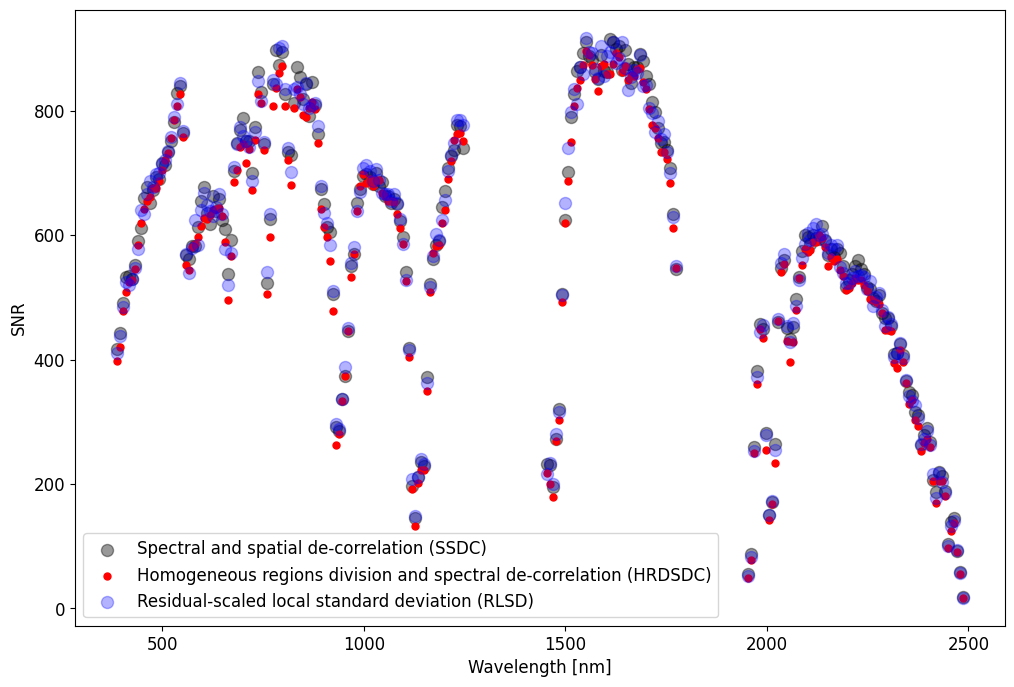

In [36]:
plt.figure(figsize= (12,8))
plt.rcParams.update({'font.size': 12})

plt.scatter(wavelengths, snr_ssdc, color='black', s=75, alpha=0.4)
plt.scatter(wavelengths, snr_hrdsdc, color='red', s=25, alpha=1.0)
plt.scatter(wavelengths, snr_rlsd, color = 'blue', s=75, alpha=0.3)


plt.legend(['Spectral and spatial de-correlation (SSDC)',
             'Homogeneous regions division and spectral de-correlation (HRDSDC)',
             'Residual-scaled local standard deviation (RLSD)'])

plt.xlabel('Wavelength [nm]')
plt.ylabel('SNR')

plt.show()